In [1]:
from pckit.comsol import ComsolModel, ComsolWorker
import pckit
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define Hashable task type
Task = namedtuple('Task', ['a', 'b'])


# Create model
class MyModel(ComsolModel):
    def pre_build(self, task: Task):
        # set parameters in Comsol model
        self.parameter(name='b', value=task.b)
        self.parameter(name='a', value=task.a)
    
    def results(self, task: Task) -> np.ndarray:
        # evaluate the Global Evaluation in Comsol model
        evaluation = self / 'evaluations' / 'Global Evaluation 1'
        dataset = (self / 'datasets').children()[0]
        evaluation.property('data', dataset)
        java = evaluation.java
        real, imag = java.computeResult()
        result = np.array(real)
        return result[:, 0]


In [3]:
# Create model, worker and solver instances
comsol_model = MyModel()
comsol_worker = ComsolWorker(model=comsol_model, filepath='acoustics_scattering.mph')
solver = pckit.SimpleSolver(comsol_worker)

Be careful with rerunning the cell above.
ComsolWorker has to be closed manually before rerunning the cell.
Otherwise the Comsol client will run forever.

In [10]:
tasks = [Task(a=1, b=1), Task(a=1, b=1.25), Task(a=1, b=1.5)]
results = solver.solve(tasks=tasks)

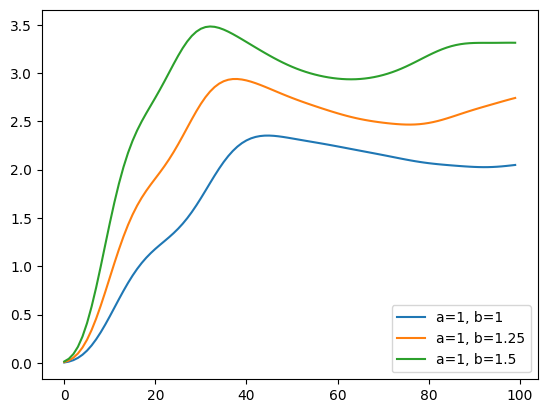

In [11]:
for result, task in zip(results, tasks):
    plt.plot(result, label=f'a={task.a}, b={task.b}')
    
plt.legend()